In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import re
from itertools import chain
import scipy
from skimage import io
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5509,00030059_006.png,Atelectasis,6,30059,069Y,M,AP,3056,2544,0.139,0.139
645,00003343_000.png,No Finding,0,3343,044Y,M,PA,2992,2991,0.143,0.143
3328,00016438_002.png,Pleural_Thickening,2,16438,066Y,M,PA,2992,2991,0.143,0.143


In [5]:
## EDA
# Todo 
img_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(img_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(img_paths.get)

Scans found: 112120 , Total Headers 5606


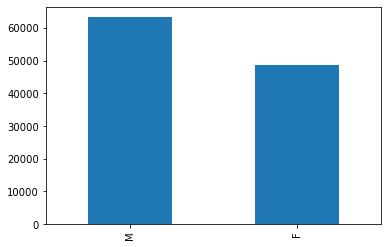

In [6]:
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

In [7]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 75]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3cd5b81cd0>]],
      dtype=object)

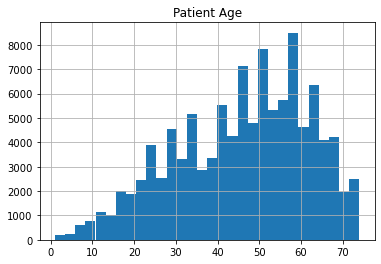

In [8]:
all_xray_df.hist('Patient Age', bins=30)

In [9]:
all_xray_df['Patient Age'].max()

74

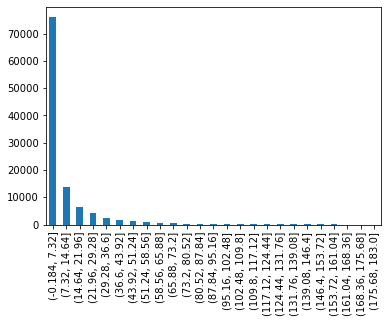

In [10]:
all_xray_df['Follow-up #'].value_counts(bins = 25).plot(kind='bar')

In [11]:
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('Labels ({}): {}'.format(len(labels), labels))
for c_label in labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5707,00001543_001.png,No Finding,1,1543,57,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19859,00005291_003.png,No Finding,3,5291,47,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82942,00020398_004.png,Effusion,4,20398,21,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

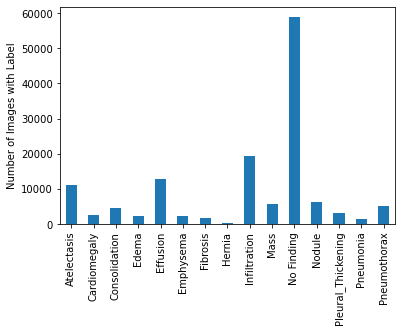

In [12]:
a_x = all_xray_df[labels].sum().plot(kind='bar')
a_x.set(ylabel = 'Number of Images with Label')

In [13]:
cases = len(all_xray_df[all_xray_df['Pneumonia'] == 1])/len(all_xray_df['Pneumonia'])
'Percentage of pneumonia cases in relation to the total is : %s' % (cases*100)

'Percentage of pneumonia cases in relation to the total is : 1.280495652014046'

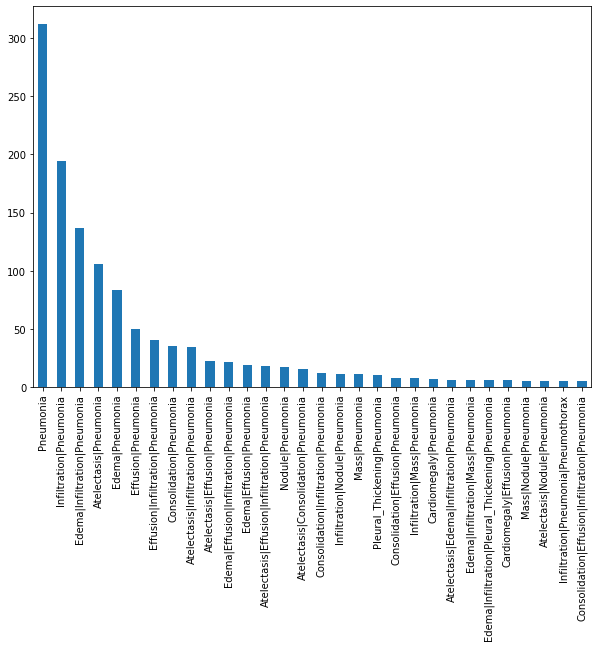

In [15]:
plt.figure(figsize=(10,7))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Text(0.5, 1.0, 'Number of pneumonia patients relative to their age')

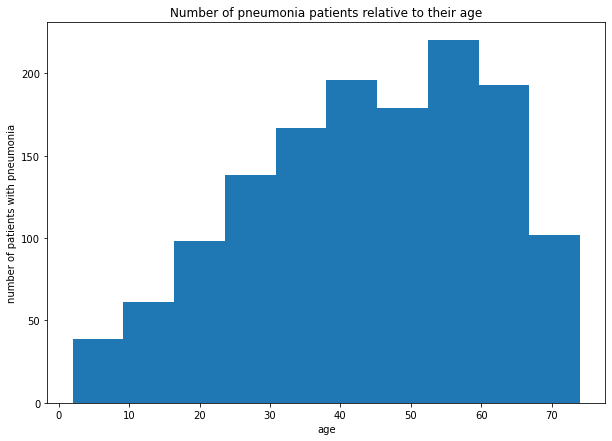

In [17]:
plt.figure(figsize=(10,7))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])
plt.ylabel('number of patients with pneumonia')
plt.xlabel('age')
plt.title('Number of pneumonia patients relative to their age')

In [18]:
'Mean age for pneumonia patients: %s years old' % (int(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'].mean()))

'Mean age for pneumonia patients: 43 years old'

Text(0.5, 1.0, 'Number of pneumonia patients relative to their sex')

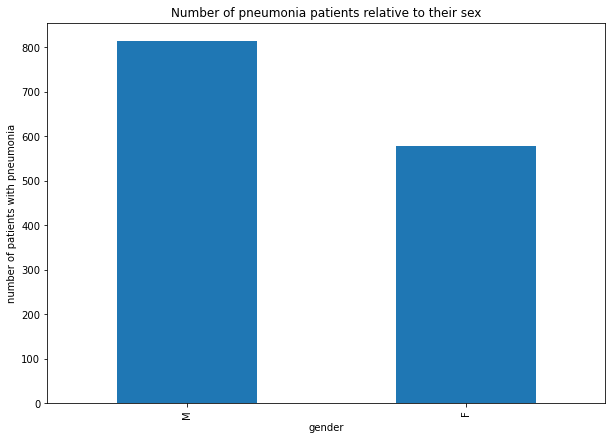

In [19]:
plt.figure(figsize=(10,7))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.ylabel('number of patients with pneumonia')
plt.xlabel('gender')
plt.title('Number of pneumonia patients relative to their sex')

In [20]:
case_df = all_xray_df.iloc[:,12:27].copy()
case_df.drop('No Finding', axis= 1, inplace = True)
case_df['sum'] = case_df.sum(axis=1)

In [21]:
case_df['age'] = all_xray_df['Patient Age']

Text(0.5, 1.0, 'Number of patients having diseases')

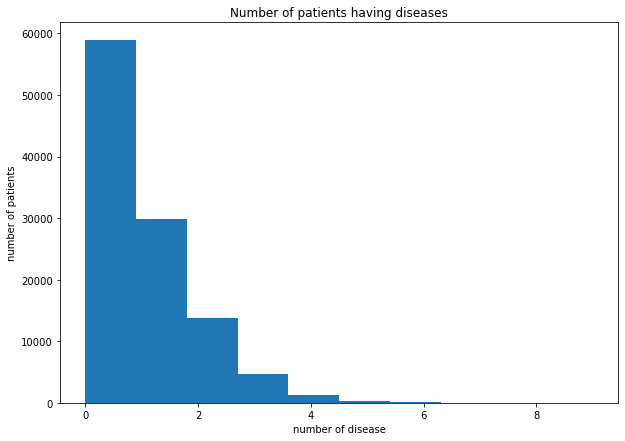

In [23]:
plt.figure(figsize=(10,7))
plt.hist(case_df['sum'])
plt.ylabel('number of patients')
plt.xlabel('number of disease')
plt.title('Number of patients having diseases')

In [24]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


In [25]:
labels2 = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels2 = [x for x in labels2 if len(x)>0]
print('All Labels ({}): {}'.format(len(labels2), labels2))
for c_label in labels2:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1691,00008806_009.png,No Finding,9,8806,034Y,F,PA,2522,2637,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
832,00004360_002.png,Effusion,2,4360,076Y,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1963,00010294_006.png,Consolidation,6,10294,050Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sample_df['pneumonia_class'] = np.where(sample_df['Pneumonia'] == 1, 'Pneumonia', 'No_pneumonia')

In [27]:
sample_df.drop('No Finding', axis=1, inplace = True)
sample_df['sum'] = sample_df.iloc[:,12:27].sum(axis=1)

In [28]:
sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,sum
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0


In [29]:
img_dir = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(img_dir.get)

In [30]:
eda = sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]
df = []
for p in range(9):
    df.append(("pneumonia", eda.iloc[p]["path_img"]))

In [31]:
df

[('pneumonia', '/data/images_004/images/00008470_008.png'),
 ('pneumonia', '/data/images_006/images/00011702_043.png'),
 ('pneumonia', '/data/images_006/images/00012158_025.png'),
 ('pneumonia', '/data/images_006/images/00012667_000.png'),
 ('pneumonia', '/data/images_006/images/00012733_000.png'),
 ('pneumonia', '/data/images_007/images/00014201_008.png'),
 ('pneumonia', '/data/images_008/images/00017714_019.png'),
 ('pneumonia', '/data/images_009/images/00019021_001.png'),
 ('pneumonia', '/data/images_009/images/00019865_013.png')]

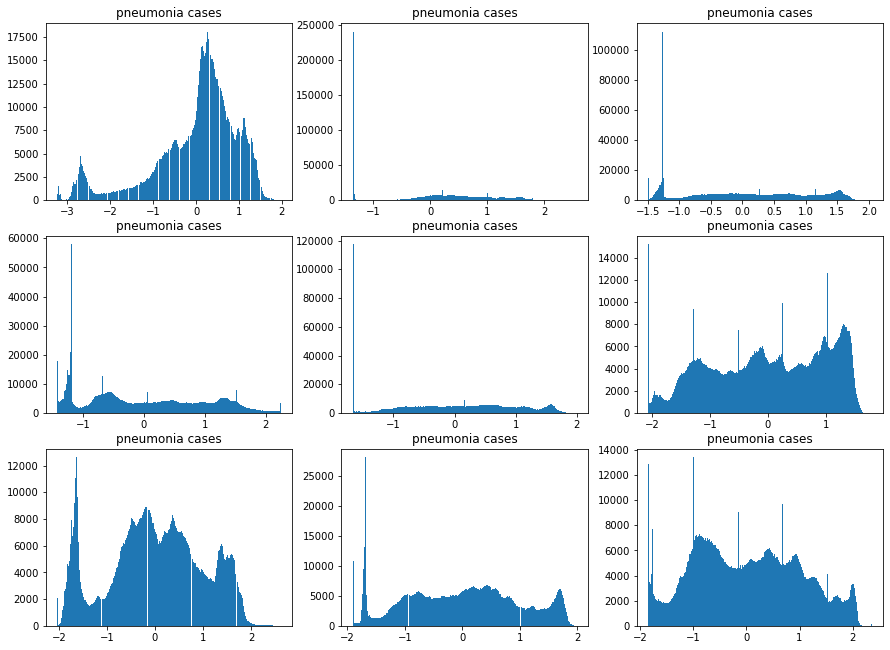

In [33]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(df) ):
    plt.subplot(len(df) / columns + 1, columns, i + 1).set_title('pneumonia cases')
    var = plt.imread(df[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [34]:
eda2 = sample_df[sample_df["pneumonia_class"] == 'No_pneumonia']
df2 = []
for p in range(9):
    df2.append(("pneumonia", eda2.iloc[p]["path_img"]))

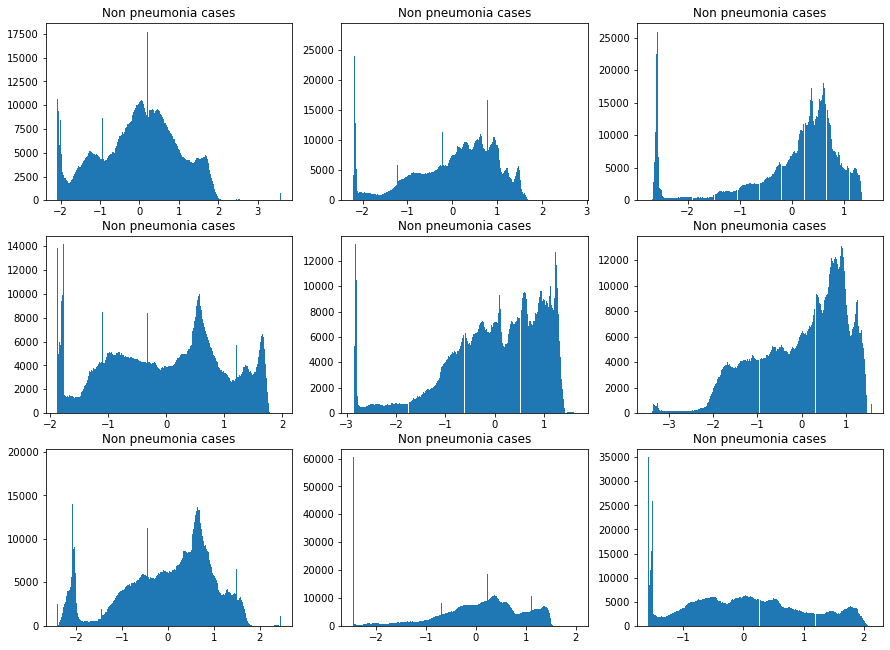

In [36]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(df2) ):
    plt.subplot(len(df2) / columns + 1, columns, i + 1).set_title('Non pneumonia cases')
    var = plt.imread(df2[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [37]:
eda3 = sample_df[sample_df["Infiltration"] ==1]
df3 = []
for p in range(9):
    df3.append(("inflitration", eda3.iloc[p]["path_img"]))

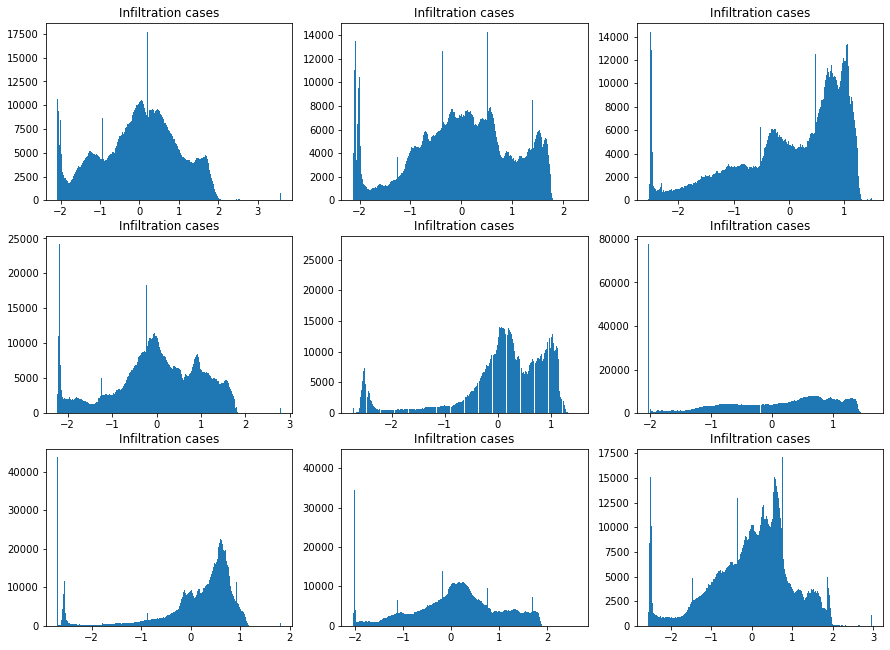

In [38]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(df3) ):
    plt.subplot(len(df3) / columns + 1, columns, i + 1).set_title('Infiltration cases')
    var = plt.imread(df3[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


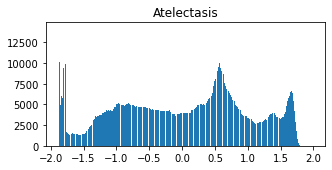

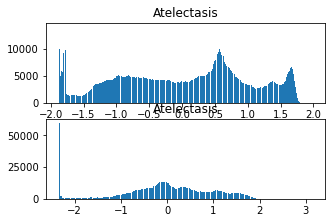

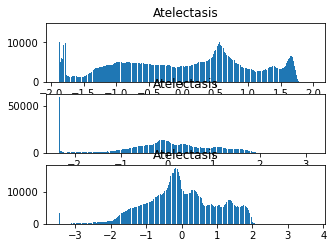

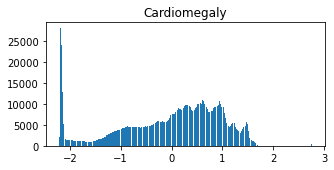

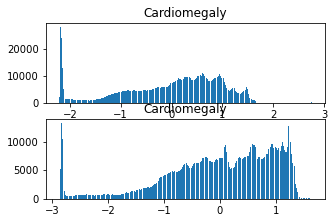

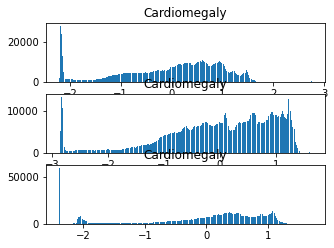

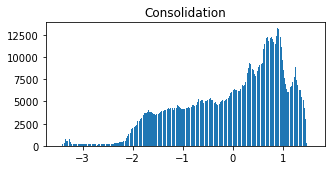

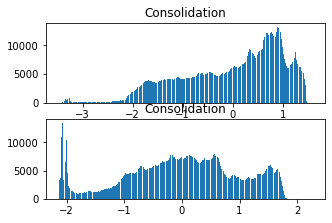

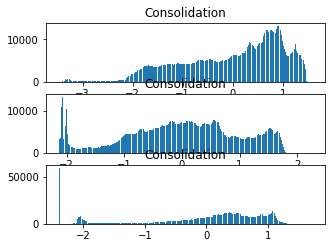

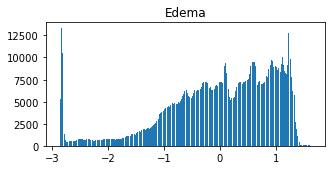

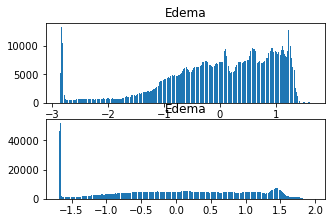

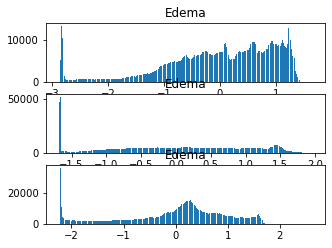

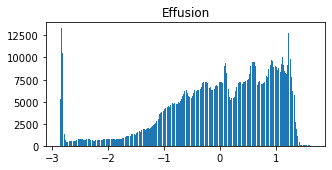

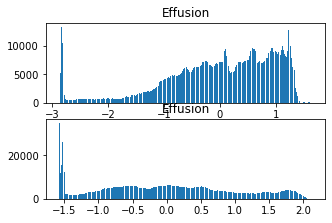

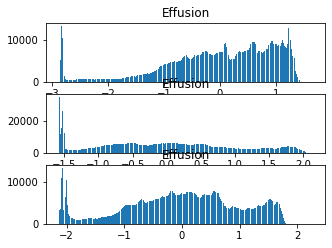

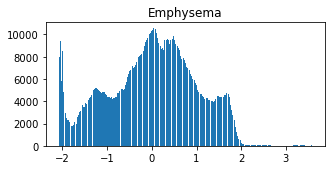

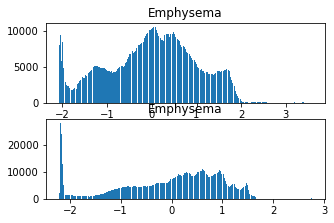

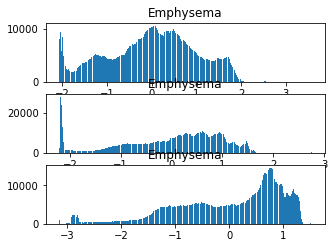

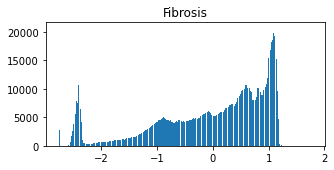

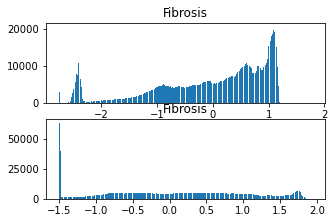

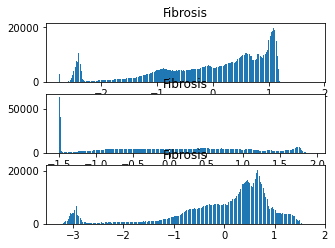

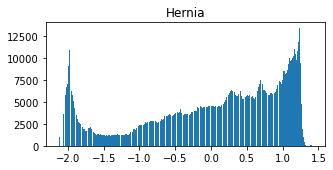

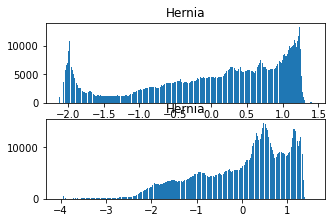

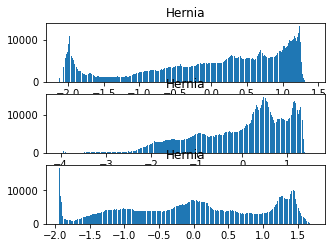

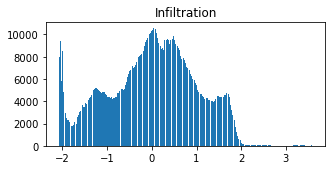

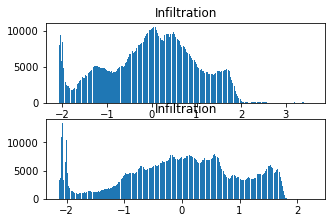

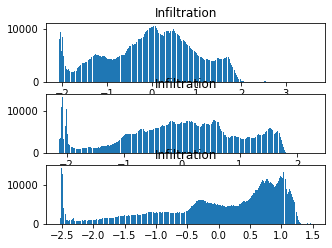

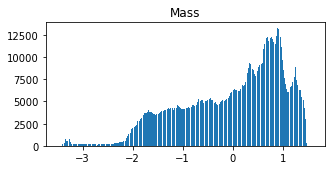

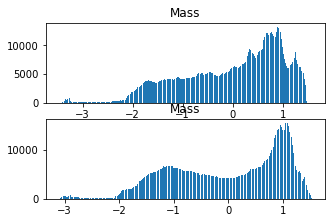

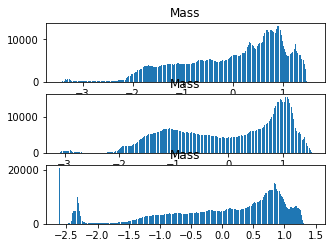

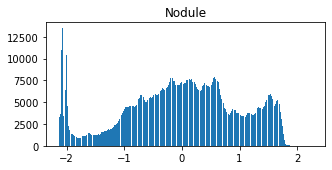

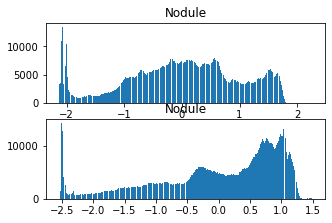

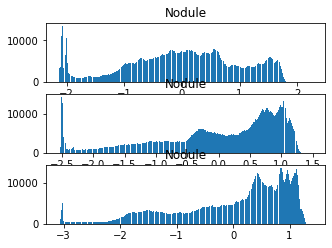

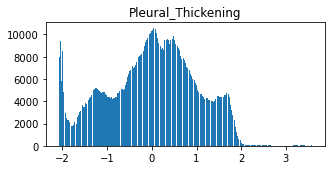

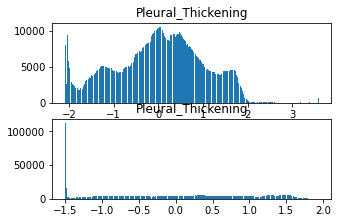

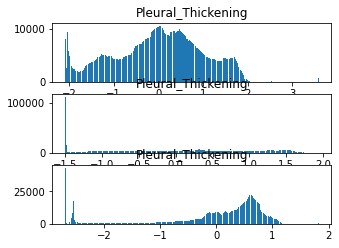

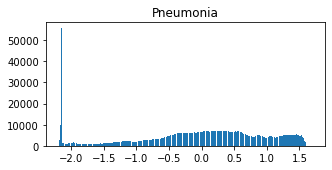

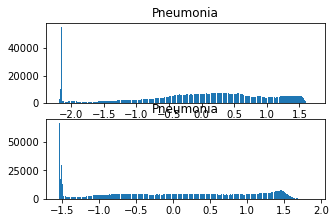

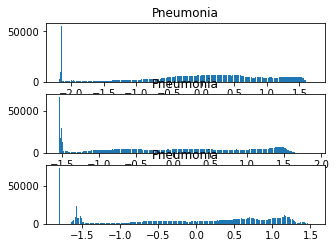

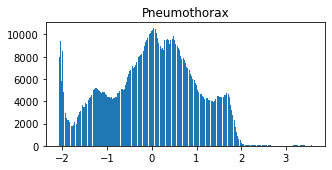

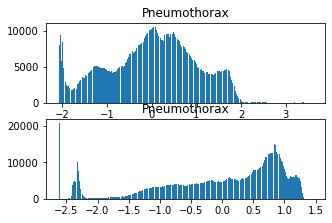

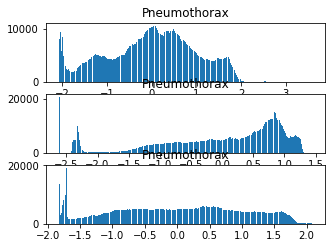

In [41]:
case_list = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']
for f in case_list:
    hist = sample_df[sample_df[f] == 1]
    data = []
    for p in range(3):
        data.append((f, hist.iloc[p]["path_img"]))
        plt.figure(figsize=(5, 5))
        columns = 1
        for i in range(len(data) ):
            plt.subplot(len(data) / columns + 1, columns, i + 1).set_title(f)
            var = plt.imread(data[i][1])
            plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=300)